In [1]:
# Importing all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import openpyxl
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# Dataset Generation

In [568]:
val_arousal = pd.read_csv("data/csv/muse_v3.csv")
val_arousal = val_arousal[['track', 'artist', 'valence_tags', 'arousal_tags', 'dominance_tags', 'genre']]
val_arousal['track'] = val_arousal['track'].str.lower()
val_arousal['artist'] = val_arousal['artist'].str.lower()
df = pd.read_csv("data/csv/tracks.csv")
df = df[['name', 'popularity', 'duration_ms', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']]
df['name'] = df['name'].str.lower()
df = df[df[['name', 'artists']].duplicated(keep = False) == False]
df = df[df['name'].isin(val_arousal['track'])]

In [569]:
def transform_row(row):
    output = ""
    for i in eval(row):
        output += i.lower() + " & "
    return output[:-3]
df['artists'] = df['artists'].apply(transform_row)

In [570]:
val_arousal.set_index(pd.MultiIndex.from_frame(val_arousal[['track', 'artist']]), inplace = True)
val_arousal = val_arousal[['valence_tags', 'arousal_tags', 'dominance_tags', 'genre']]

In [571]:
merged_df = df.join(val_arousal, on = ['name', 'artists'], how = 'inner')

In [572]:
merged_df

,name,popularity,duration_ms,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,valence_tags,arousal_tags,dominance_tags,genre
154,need a little sugar in my bowl,27,167640,bessie smith,0.693,0.0270,0,-13.506,0,0.0562,0.99200,0.000000,0.1340,0.402,75.749,4,3.909552,4.298881,5.670896,blues
3895,i know his blood can make me whole,16,182840,blind willie johnson,0.559,0.2100,1,-13.594,0,0.0718,0.97100,0.000017,0.1030,0.550,105.208,4,3.686071,3.739643,5.532143,blues
5543,it's all forgotten now,11,203067,al bowlly,0.582,0.0317,0,-21.242,1,0.0462,0.98800,0.000261,0.0595,0.244,81.228,4,3.933333,5.783333,4.220000,jazz
6476,caroni swamp,4,179435,phil madison,0.611,0.2860,5,-10.853,1,0.2170,0.99400,0.000001,0.4050,0.452,82.857,4,6.650000,4.770000,5.310000,NaN
8105,till the cows come home,36,172973,lucille bogan,0.682,0.1320,7,-11.006,1,0.1210,0.98700,0.000000,0.1850,0.731,118.436,4,5.495000,5.490000,5.957500,jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585654,batman,19,94307,the who,0.515,0.8670,2,-2.910,1,0.0474,0.00129,0.392000,0.1560,0.123,141.202,4,6.720000,4.860000,6.500000,rock
586003,moon and the stars,22,214960,earl klugh,0.384,0.1200,7,-24.773,1,0.0429,0.95400,0.925000,0.1160,0.877,174.110,4,6.760000,3.310000,6.380000,smooth jazz
586073,(song for my) sugar spun sister,24,204800,the stone roses,0.362,0.5700,9,-16.262,1,0.0369,0.07560,0.001670,0.2260,0.571,121.032,4,6.316129,4.552903,5.738065,indie
586481,unfriend you,48,200800,greyson chance,0.624,0.8930,7,-4.317,1,0.0496,0.00278,0.000000,0.0589,0.537,130.939,4,3.630000,4.640000,4.580000,pop


In [573]:
#merged_df.to_csv("data/csv/prediction_dataset.csv")

In [574]:
merged_df.columns

Index(['name', 'popularity', 'duration_ms', 'artists', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'valence_tags', 'arousal_tags', 'dominance_tags', 'genre'],
      dtype='object')

# Linear Regression

In [9]:
def residual(regression_model, X_test, y_test):
    # inputs: the regression model, test X and test y from the previous question
    # output: a list of residuals corresponding to each X in the input
    predictions = regression_model.predict(X_test)
    return y_test - predictions

def plotResidualHistogram(regression_model, X_test, y_test):
    # inputs: the regression model, test X and test y from the previous question
    # Compute the residuals using the previous residual function
    # Loop through the attributes and plot a histogram for the residuals
    # Output: None, simply plot the histogram
    residuals = residual(regression_model, X_test, y_test)
    plt.hist(residuals, bins = 100)
    plt.title('Residual Histogram')
    plt.xlabel('Residual')
    plt.ylabel('Num of Observations')
    plt.show()
    return

def plotResidualsVsAttributes(regression_model, X_test, y_test, attributes):
    # inputs: the regression model, test X and test y from the previous question, and a list of columns to plot residuals against
    # Compute the residuals using the previous function
    # Loop through the attributes and plot a scatter plot for each column's data and the residuals
    # Output: None, simply plot the graphs
    residuals = residual(regression_model, X_test, y_test)
    for attr in attributes:
        plt.scatter(X_test[attr], residuals)
        plt.title('Scatter plot of Residual vs {}'.format(attr))
        plt.xlabel(attr)
        plt.ylabel('Residual')
        plt.show()
    return

In [10]:
X = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
     'instrumentalness', 'liveness', 'valence', 'tempo', 'valence_tags', 'arousal_tags', 'dominance_tags']
Y = 'popularity'
np.random.seed(448)
#for genre in genres:
#    model_df = merged_df[merged_df['genre'] == genre]
#    X_train, X_test, y_train, y_test = train_test_split(model_df.loc[:, X], 
#                                                        model_df[Y], 
#                                                        test_size = 0.2)
#    temp = pd.concat([X_train, y_train], axis = 1)
#    temp.to_excel(f"data/linear_model/{genre}.xlsx")

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, X], 
#                                                        merged_df[Y], 
#                                                        test_size = 0.2)
#temp = pd.concat([X_train, y_train], axis = 1)
#temp.to_excel(f"data/linear_model/all_genre.xlsx")

In [12]:
X_dict = {
    "rock": ['danceability', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'valence_tags'],
    "jazz": ['duration_ms', 'danceability', 'instrumentalness', 'valence_tags', 'arousal_tags'],
    "electronic": ['key'],
    "country": ['duration_ms', 'tempo', 'arousal_tags']
}
#X = ['valence_tags', 'arousal_tags']
genres = ['rock', 'jazz', 'electronic', 'country']

In [13]:
merged_df = merged_df[merged_df['genre'].isin(genres)]

In [14]:
merged_df['genre'].value_counts()

rock          754
jazz          214
electronic    167
country        88
Name: genre, dtype: int64

---------------rock--------------------

                  danceability  loudness  speechiness  instrumentalness  \
danceability          1.000000 -0.013798     0.019441         -0.135239   
loudness             -0.013798  1.000000     0.030956         -0.147267   
speechiness           0.019441  0.030956     1.000000         -0.028871   
instrumentalness     -0.135239 -0.147267    -0.028871          1.000000   
valence               0.503993  0.187468     0.134489         -0.062304   
valence_tags          0.113533  0.206193     0.033053         -0.036570   
popularity            0.009723  0.347400    -0.090078         -0.130496   

                   valence  valence_tags  popularity  
danceability      0.503993      0.113533    0.009723  
loudness          0.187468      0.206193    0.347400  
speechiness       0.134489      0.033053   -0.090078  
instrumentalness -0.062304     -0.036570   -0.130496  
valence           1.000000      0.107384   -0.134471  
valence_tags      0.107384  

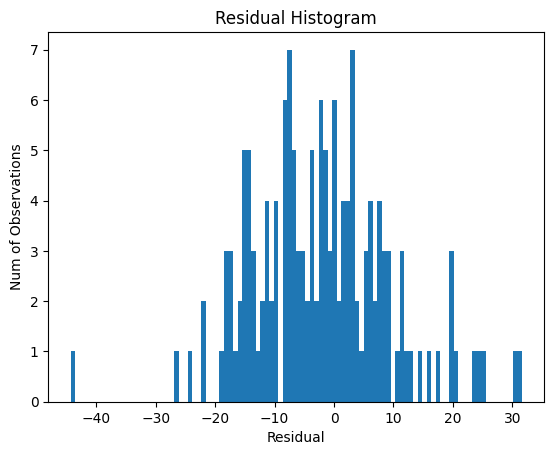

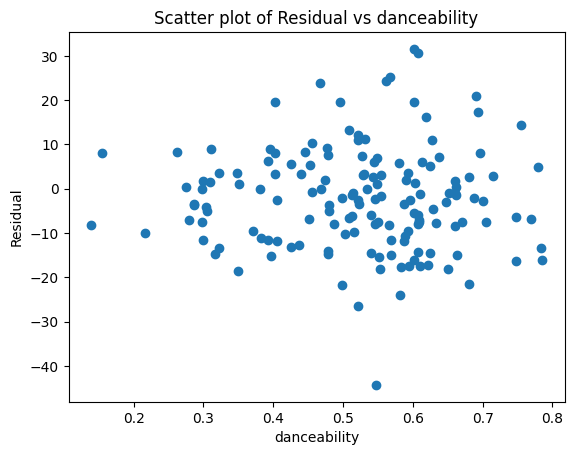

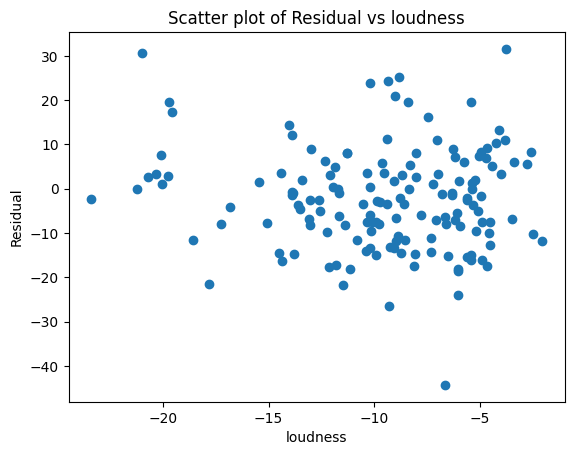

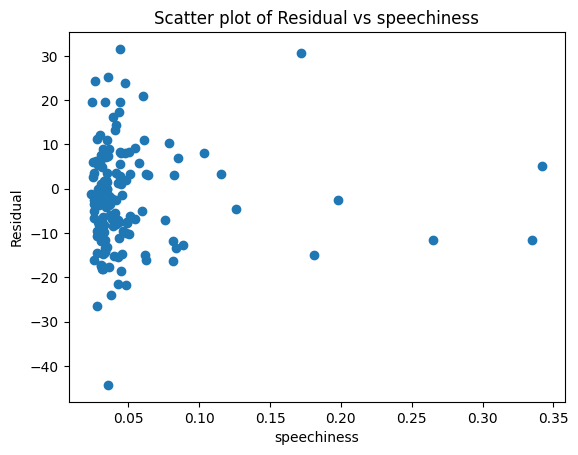

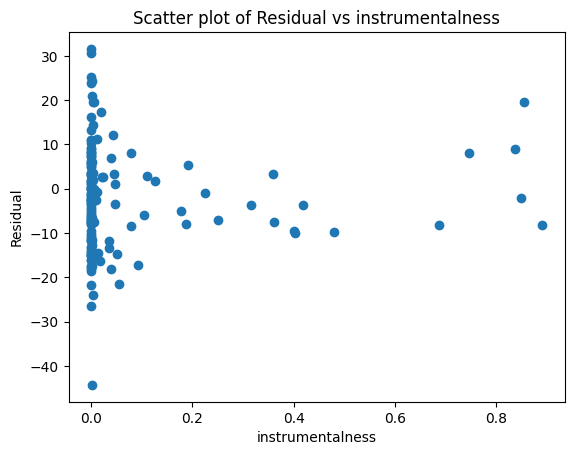

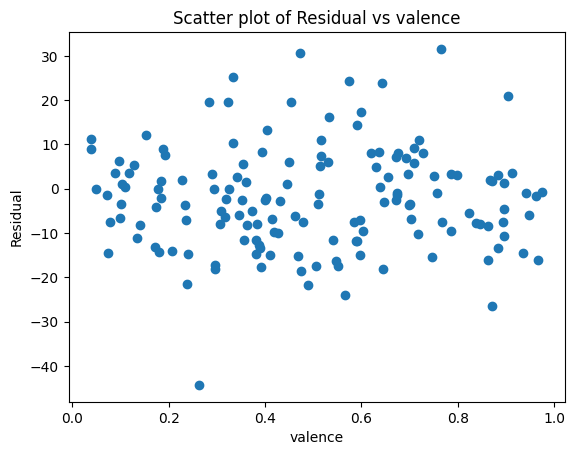

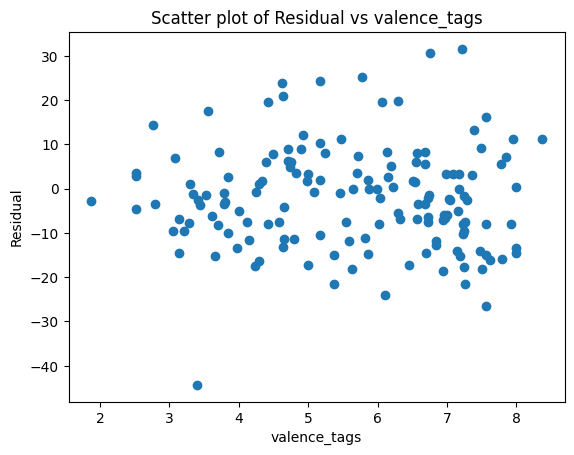

---------------jazz--------------------

                  duration_ms  danceability  instrumentalness  valence_tags  \
duration_ms          1.000000     -0.060691          0.168413     -0.132444   
danceability        -0.060691      1.000000          0.046637      0.056160   
instrumentalness     0.168413      0.046637          1.000000      0.053126   
valence_tags        -0.132444      0.056160          0.053126      1.000000   
arousal_tags        -0.096547      0.257388         -0.024016      0.436952   
popularity           0.108004      0.071048         -0.114209      0.167212   

                  arousal_tags  popularity  
duration_ms          -0.096547    0.108004  
danceability          0.257388    0.071048  
instrumentalness     -0.024016   -0.114209  
valence_tags          0.436952    0.167212  
arousal_tags          1.000000    0.061606  
popularity            0.061606    1.000000  
R2 of training: 0.06672541908624474
R2 of test: 0.025986990830448975
MSE: 186.266686852523

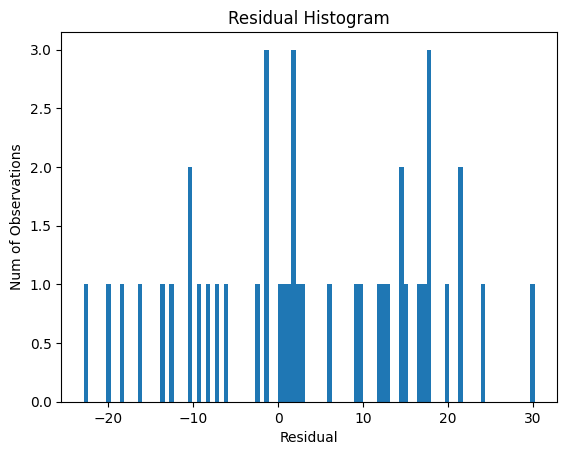

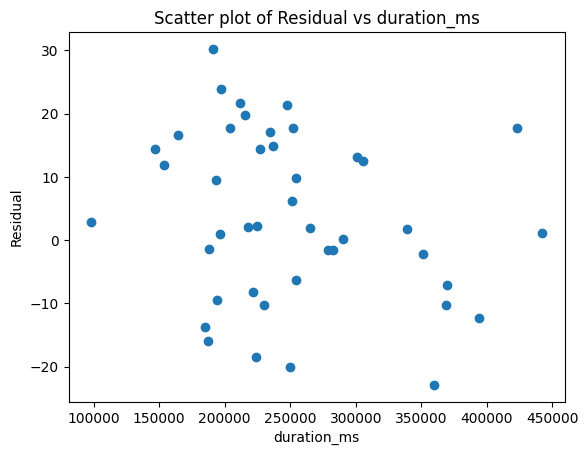

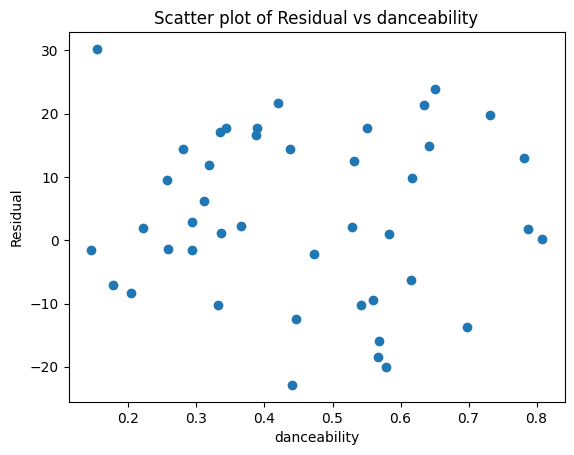

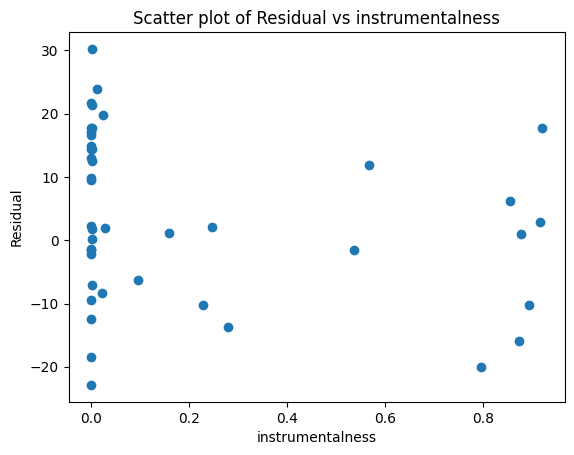

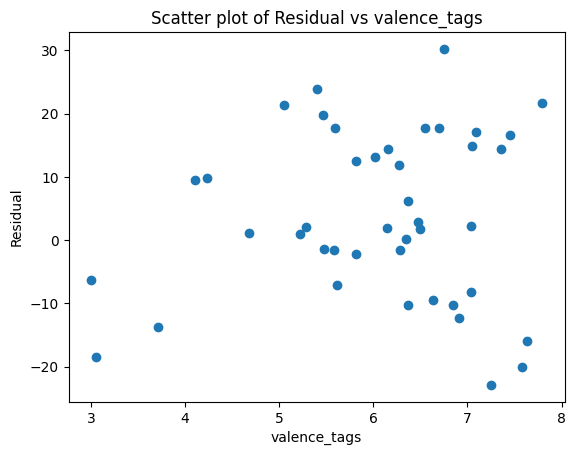

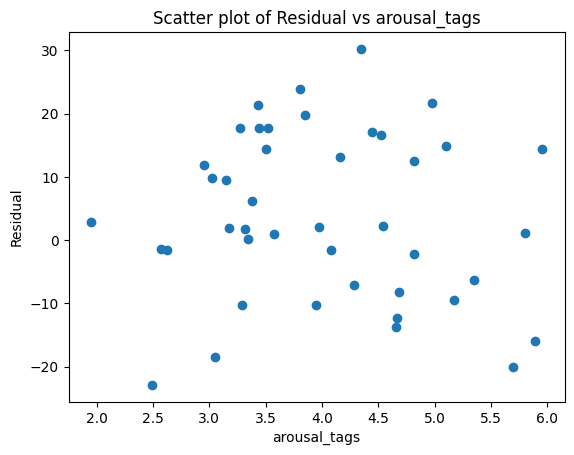

---------------electronic--------------------

                 key  popularity
key         1.000000   -0.166435
popularity -0.166435    1.000000
R2 of training: 0.02615491497169742
R2 of test: 0.02458986231853688
MSE: 245.7636970171206
MAE: 12.616095343152994


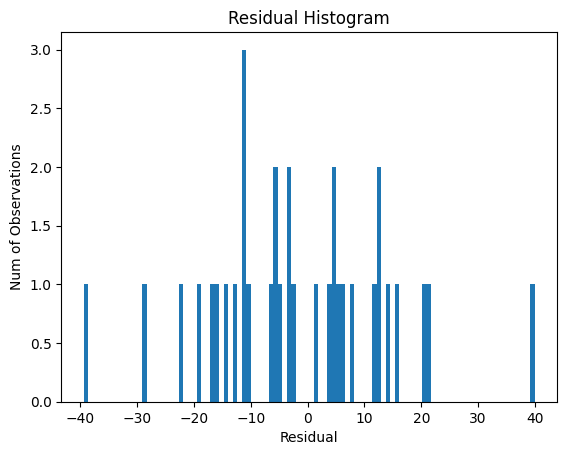

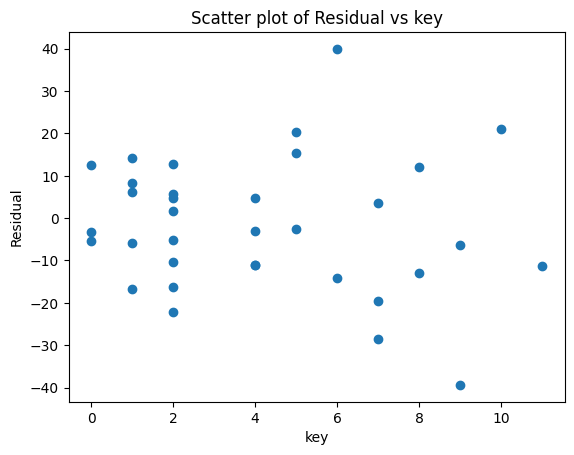

---------------country--------------------

              duration_ms     tempo  arousal_tags  popularity
duration_ms      1.000000 -0.048363     -0.204239    0.257906
tempo           -0.048363  1.000000      0.136904    0.193505
arousal_tags    -0.204239  0.136904      1.000000    0.253055
popularity       0.257906  0.193505      0.253055    1.000000
R2 of training: 0.16610129059991174
R2 of test: 0.2766989867263121
MSE: 142.9635706482931
MAE: 9.163907549723069


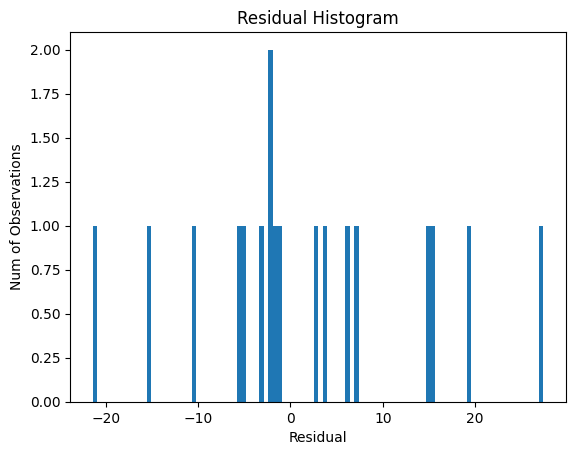

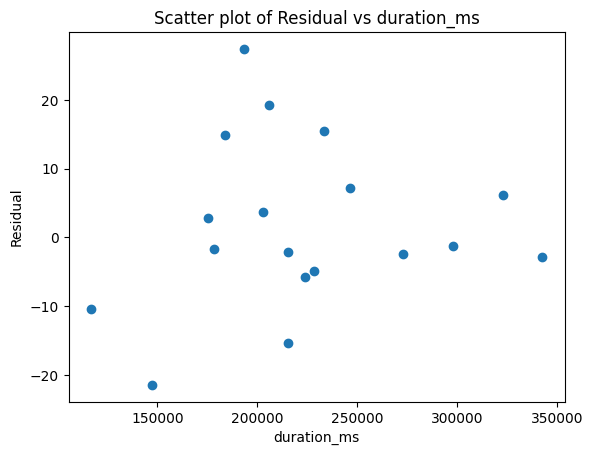

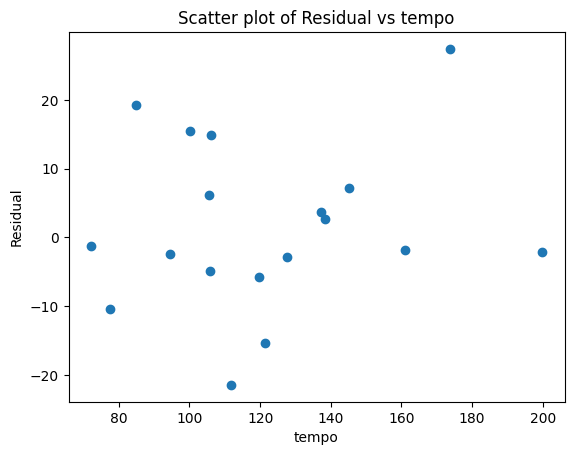

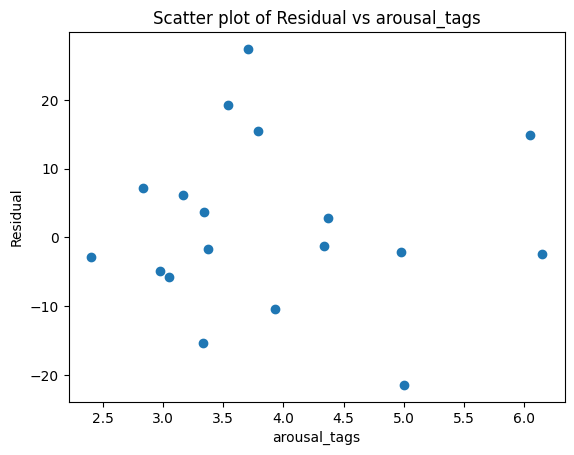

In [15]:
for genre in genres:
    print(f"---------------{genre}--------------------")
    X = X_dict[genre]
    model_df = merged_df[merged_df['genre'] == genre]
    print()
    model_df = model_df[X + [Y]]
    print(model_df.corr())
    np.random.seed(448)
    X_train, X_test, y_train, y_test = train_test_split(model_df.loc[:, X], 
                                                        model_df[Y], 
                                                        test_size = 0.2)
    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)
    r2_training = regression_model.score(X_train, y_train)
    r2_test = regression_model.score(X_test, y_test)
    print(f"R2 of training: {r2_training}")
    print(f"R2 of test: {r2_test}")
    print(f"MSE: {(np.square(residual(regression_model, X_test, y_test)).sum()) / len(X_test)}")
    print(f"MAE: {(np.absolute(residual(regression_model, X_test, y_test)).sum()) / len(X_test)}")
    plotResidualHistogram(regression_model, X_test, y_test)
    plotResidualsVsAttributes(regression_model, X_test, y_test, X)

# Clustering and GMM

In [567]:
# large dataset without valence/arousal tags
#merged_df = pd.read_csv("data/csv/tracks.csv")
#print(merged_df.columns, len(merged_df))
#merged_df.head()

(array([4.4690e+04, 1.2024e+04, 9.6390e+03, 8.1540e+03, 7.7330e+03,
        7.7300e+03, 7.6590e+03, 7.7260e+03, 7.9880e+03, 8.2650e+03,
        8.0190e+03, 8.0980e+03, 7.9850e+03, 8.5120e+03, 8.7470e+03,
        8.7250e+03, 9.2690e+03, 9.1370e+03, 9.4660e+03, 1.0324e+04,
        1.0098e+04, 1.0534e+04, 1.1206e+04, 1.2139e+04, 1.1148e+04,
        1.0876e+04, 1.0937e+04, 1.1292e+04, 1.1146e+04, 1.0835e+04,
        1.0171e+04, 1.0414e+04, 1.0773e+04, 1.1174e+04, 1.1328e+04,
        1.2231e+04, 1.1879e+04, 1.0808e+04, 1.0100e+04, 1.0063e+04,
        9.9490e+03, 9.5940e+03, 9.1060e+03, 8.7890e+03, 8.4720e+03,
        8.1200e+03, 7.3180e+03, 7.0670e+03, 6.8360e+03, 6.5360e+03,
        6.2400e+03, 6.0230e+03, 5.5880e+03, 5.2640e+03, 4.9640e+03,
        4.5860e+03, 4.2900e+03, 3.9060e+03, 3.6420e+03, 3.4960e+03,
        2.9760e+03, 2.8060e+03, 2.6250e+03, 2.3590e+03, 2.0860e+03,
        1.9100e+03, 1.7150e+03, 1.4790e+03, 1.3350e+03, 1.2300e+03,
        1.1100e+03, 9.6800e+02, 8.4600e+02, 7.32

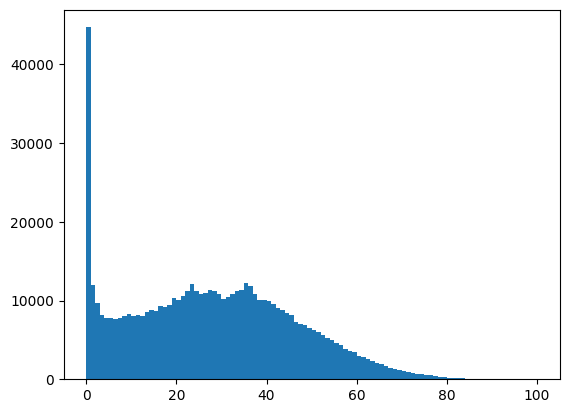

In [553]:
plt.hist(merged_df['popularity'], bins = 100)

In [596]:
model_df = merged_df[merged_df['genre'] == 'rock']
#model_df = merged_df
np.random.seed(448)
#X = X_dict['jazz']
#X = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
#     'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
X = ['valence_tags', 'arousal_tags']
X_train, X_test, y_train, y_test = train_test_split(model_df.loc[:, X], 
                                                    model_df[Y], 
                                                    test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [576]:
def predict(song_input, GMM_models):
    scores = []
    for model in GMM_models:
        scores.append(model.score(song_input).sum())
    #return (np.argmax(scores), quantile_levels[np.argmax(scores)] / 2)
    return np.argmax(scores)

In [577]:
def testData(X_test, y_test, GMM_models, num_groups, quantile_levels):
    total = len(y_test)
    correct = 0
    #loss = 0
    for index, row in X_test.iterrows():
        prediction = predict(np.array(row).reshape(1,-1), GMM_models)
        #prediction, pop_level = predict(np.array(row).reshape(1,-1), GMM_models)
        #loss += (y_test.loc[index] - pop_level) ** 2
        correct_label = None
        for i in range(num_groups):
            if y_test.loc[index] < quantile_levels[i]:
                correct_label = i
                break
        if correct_label is None:
            correct_label = i
        if prediction == correct_label:
            correct += 1
    return correct/total

In [578]:
len(model_df)

6420

In [579]:
def GMM_performance():
    perf_dict = {}
    config = {}
    for num_groups in [2, 3, 4]:
        print("--------------------")
        print(f"Num_groups: {num_groups}")
        groupings = []
        temp_df = pd.concat([X_train, y_train], axis = 1)
        quantile_levels = []
        for i in range(num_groups):
            temp = temp_df[(temp_df['popularity'] < temp_df['popularity'].quantile((1 + i )/ num_groups)) & 
                            (temp_df['popularity'] >= temp_df['popularity'].quantile(i / num_groups))]
            temp.drop('popularity', axis=1, inplace = True)
            groupings.append(temp)
            quantile_levels.append(temp_df['popularity'].quantile((1 + i )/ num_groups))

        max_perf = 0
        chosen_components = None
        test_perf = None
        for num_components in range(15)[1:]:
            GMM_models = []
            for j in range(num_groups):
                model = GaussianMixture(n_components = num_components, 
                                        max_iter = 200, 
                                        covariance_type='diag', 
                                        n_init = 5,
                                        random_state = 448,
                                        init_params = "k-means++")
                model.fit(groupings[j])
                GMM_models.append(model)

            if testData(X_val, y_val, GMM_models, num_groups, quantile_levels) > max_perf:
                max_perf = testData(X_val, y_val, GMM_models, num_groups, quantile_levels)
                chosen_components = num_components
                test_perf = testData(X_test, y_test, GMM_models, num_groups, quantile_levels)
            
        perf_dict[num_groups] = [max_perf, test_perf]
        config[num_groups] = chosen_components
            
    return perf_dict, config

In [597]:
perf_dict, config = GMM_performance()

--------------------
Num_groups: 2
--------------------
Num_groups: 3
--------------------
Num_groups: 4


In [598]:
config

{2: 12, 3: 4, 4: 4}

In [599]:
perf_dict

{2: [0.628099173553719, 0.6423841059602649],
 3: [0.4214876033057851, 0.4503311258278146],
 4: [0.34710743801652894, 0.3443708609271523]}

# Random Forest

In [444]:
from sklearn.ensemble import RandomForestClassifier
import itertools

In [590]:
model_df = merged_df[merged_df['genre'] == 'rock']
#model_df = merged_df
np.random.seed(448)
#X = X_dict['jazz']
#X = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
#     'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'valence_tags', 'arousal_tags']
X = ['valence_tags', 'arousal_tags']
X_train, X_test, y_train, y_test = train_test_split(model_df.loc[:, X], 
                                                    model_df[Y], 
                                                    test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [591]:
def RF_performance():
    perf_dict = {}
    config = {}
    for num_groups in [2,3,4]:        
        temp_df = pd.concat([X_train, y_train], axis = 1)
        quantile_levels = []
        for i in range(num_groups):
            quantile_levels.append(temp_df['popularity'].quantile((1 + i )/ num_groups))
        def transform_y(y_values):
            output = []
            for y_value in y_values:
                transformed = None
                for i in range(num_groups):
                    if y_value <= quantile_levels[i]:
                        transformed = i
                        break
                if not transformed:
                    transformed = i
                output.append(transformed)
            return output
        new_y_train = transform_y(y_train)
        new_y_val = transform_y(y_val)
        new_y_test = transform_y(y_test)
        max_perf = 0
        chosen_components = None
        test_perf = None
        
        for num_trees, max_depth in list(itertools.product([50, 100, 150], [5, 7, 10])):
            clf = RandomForestClassifier(n_estimators = num_trees, 
                                         max_depth=max_depth, 
                                         random_state=448,
                                         class_weight = "balanced_subsample",
                                         max_samples = 0.8)
            clf.fit(X_train, new_y_train)
            
            if UAR_metric(clf, X_val, new_y_val) > max_perf:
                max_perf = UAR_metric(clf, X_val, new_y_val)
                setting = [num_trees, max_depth]
                test_perf = UAR_metric(clf, X_test, new_y_test)
        
        perf_dict[num_groups] = [max_perf, test_perf]
        config[num_groups] = setting
        
    return perf_dict, config
        

In [592]:
def UAR_metric(clf, dataset, true_values):
    predictions = clf.predict(dataset)
    correct = 0
    for pred, target in zip(predictions, true_values):
        if pred == target:
            correct += 1
    return correct / len(true_values)

In [593]:
perf_dict, config = RF_performance()

In [594]:
perf_dict

{2: [0.628099173553719, 0.6490066225165563],
 3: [0.4462809917355372, 0.45695364238410596],
 4: [0.3140495867768595, 0.2781456953642384]}

In [595]:
config

{2: [150, 5], 3: [100, 5], 4: [100, 7]}